In [1]:
import pickle

In [2]:
with open('../../cm_train_contrastive_tupels.pkl', 'rb') as f:
    list_moral_tupels = pickle.load(f)

In [ ]:
list_moral_tupels

In [4]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from data.mft_dim import moral_foundations, generate_mc_prompts

In [5]:
dataset = generate_mc_prompts(moral_foundations, instruct_model=True)

In [ ]:
dataset

In [7]:
from transformer_lens import HookedTransformer
import transformer_lens.utils as utils

In [ ]:
model = HookedTransformer.from_pretrained("google/gemma-2-9b-it")

In [ ]:
entry = 22
print(dataset[entry]["correct_answer"])
utils.test_prompt(dataset[entry]["prompt"], " A", model)


In [ ]:
print(model.to_str_tokens( " A, B,A,B"))
tokens = model.to_tokens(" A, B,A,B")
print(tokens)
model.to_string(tokens)

In [11]:
logits = model.run_with_cache(dataset[entry]["prompt"], return_type="logits")



In [ ]:
print(logits[0][0,-1,586])
print(logits[0][0,-1,599])


In [ ]:
import torch
print(torch.argmax(logits[0][0,-1,:]))
prob = torch.softmax(logits[0][0,-1,:], dim=-1)
print(prob)
print(prob[586])
print(prob[599])


In [ ]:
correct_predictions = 0
total = len(dataset)

for idx, entry in enumerate(dataset):
    # Get logits for the prompt
    logits = model.run_with_cache(entry["prompt"], return_type="logits")
    
    # Get probabilities for the last position
    probs = torch.softmax(logits[0][0,-1,:], dim=-1)
    
    # Get token IDs for " A" and " B"
    token_A = 586  # Usually will be around 586
    token_B = 599  # Usually will be around 599
    
    # Get the model's prediction (A or B based on higher probability)
    pred = "A" if probs[token_A] > probs[token_B] else "B"
    
    # Compare with correct answer
    is_correct = pred == entry["correct_answer"]
    correct_predictions += int(is_correct)
    
    print(f"Entry {idx}: Predicted {pred}, Correct {entry['correct_answer']}, "
          f"Prob A: {probs[token_A]:.3f}, Prob B: {probs[token_B]:.3f}, "
          f"{'✓' if is_correct else '✗'}")

accuracy = correct_predictions / total
print(f"\nOverall accuracy: {accuracy:.2%}")

In [ ]:
from data.mft_dim import get_moral_statements
moral_statements = get_moral_statements(dimension="care", moral=True)
moral_statements

In [ ]:
utils.test_prompt(moral_statements[0]["prompt"], "agree", model)

In [ ]:
model.to_tokens("agree")

In [19]:
prompt = "Do you agree or disagree with the following Statement: One should never come to the aid of a stranger in distress. Moral dimension: care. Do agree or disagree? (max 15 words) "

In [ ]:
model.eval()  # Ensure the model is in evaluation mode

# Generate tokens
num_tokens_to_generate = 60
generated_text = model.generate(prompt, max_new_tokens=num_tokens_to_generate)

# Print the generated text
print(generated_text)

In [ ]:
prompt

In [ ]:
# Initialize lists to store probabilities
agree_probs = []
disagree_probs = []
generated_tokens = []

# Get initial tokens
tokens = model.to_tokens(prompt)
initial_len = tokens.shape[1]

# Generate one token at a time and get probabilities
for i in range(num_tokens_to_generate):
    # Get logits for next token
    logits = model(tokens)[:,-1]
    probs = torch.softmax(logits, dim=-1)
    
    # Get probabilities for agree/disagree tokens
    agree_token = model.to_tokens(" agree")[0,1]  
    disagree_token = model.to_tokens(" disagree")[0,1]
    
    agree_prob = probs[0,agree_token].item()
    disagree_prob = probs[0,disagree_token].item()
    
    agree_probs.append(agree_prob)
    disagree_probs.append(disagree_prob)
    
    # Sample next token
    next_token = torch.multinomial(probs[0], num_samples=1)
    tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
    
    # Store generated token
    generated_tokens.append(model.to_string(next_token.unsqueeze(0)))
    
    # Break if EOS token generated
    if next_token.item() == model.tokenizer.eos_token_id:
        break

# Print probabilities and tokens at each step
for i, (token, agree_p, disagree_p) in enumerate(zip(generated_tokens, agree_probs, disagree_probs)):
    print(f"Position {i+initial_len} ({token}): Agree prob: {agree_p:.3f}, Disagree prob: {disagree_p:.3f}")


In [ ]:

# Calculate total probabilities
total_agree = sum(agree_probs)
total_disagree = sum(disagree_probs)
mean_agree = total_agree / len(agree_probs)
mean_disagree = total_disagree / len(disagree_probs)
highest_agree = max(agree_probs)
highest_disagree = max(disagree_probs)

print(f"\nMean probability for Agree: {mean_agree:.3f}")
print(f"Mean probability for Disagree: {mean_disagree:.3f}")

print(f"Highest probability for Agree: {highest_agree:.3f}")
print(f"Highest probability for Disagree: {highest_disagree:.3f}")

print(f"Total probability for Agree: {total_agree:.3f}")
print(f"Total probability for Disagree: {total_disagree:.3f}")




### Moral Analyzer whole sequence

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from data.mft_dim import moral_foundations, generate_mc_prompts, get_moral_statements, get_moral_keys
from src.analysis.moral_analyzer import MoralBehaviorAnalyzer
from transformer_lens import HookedTransformer

In [2]:
model = HookedTransformer.from_pretrained("google/gemma-2-9b-it", dtype="bf16")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/root/miniconda/envs/mech/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Loaded pretrained model google/gemma-2-9b-it into HookedTransformer


In [3]:
analyzer = MoralBehaviorAnalyzer(model)

Initialized collector with 42 layers and 14336 neurons per layer


In [4]:
get_moral_keys()

['care', 'fairness', 'loyalty', 'authority', 'sanctity', 'liberty']

In [5]:
category = "liberty"

In [6]:
# Data list of moral statements and immoral statements
moral_statements = get_moral_statements(dimension=category, moral=True)
immoral_statements = get_moral_statements(dimension=category, moral=False)

moral_pairs = [(statement["statement"], immoral_statements[i]["statement"]) for i, statement in enumerate(moral_statements)]

moral_pairs[0]

('Citizens should be free to criticize the government without fear of punishment.',
 'Challenging the government openly should be restricted for the sake of order.')

In [7]:
moral_pairs[1]

('Individuals should have the freedom to make personal choices about their bodies.',
 'Authorities ought to regulate people’s bodily decisions for society’s greater good.')

In [8]:
results = analyzer.analyze_moral_behavior(
    moral_pairs,
    temporal_window=5
)

Analyzing moral pairs:   0%|          | 0/40 [00:00<?, ?it/s]


Activation difference statistics:
Maximum difference: 7.380038
Mean absolute difference: 0.008569

Difference distribution percentiles:
0th percentile: -7.380038
25th percentile: -0.003870
50th percentile: 0.000000
75th percentile: 0.003867
100th percentile: 6.414859

Moral Neuron (18, 3761):
Mean difference: 0.319605
Consistency: 0.555263
Most consistent positions: [(17, 0.0), (18, 0.02500000037252903), (0, 0.05000000074505806)]
Sample-wise means: [0.21354052424430847, 0.8569175601005554, 0.2193622589111328, 0.29887938499450684, 0.12440267205238342, 0.058847326785326004, 0.17708979547023773, 0.46309059858322144, -0.01027960516512394, 0.3176687955856323, 0.4401780068874359, 0.768307626247406, 0.02835110016167164, -0.0009184385417029262, 0.48980221152305603, 0.5186112523078918, 0.202445387840271, 0.1697419285774231, 0.045676182955503464, 0.33659324049949646, 0.31431981921195984, 0.6152200102806091, 0.1673143357038498, 0.025076916441321373, 0.4094637930393219, 0.2833399474620819, 0.6849

In [17]:
# Print each key and its type to identify tensors and non-serializable objects
for key, value in results.items():
    print(f"{key}: {type(value)}")
    if hasattr(value, 'shape'):
        print(f"  Shape: {value.shape}")

moral_neurons: <class 'list'>
immoral_neurons: <class 'list'>
temporal_patterns: <class 'dict'>
key_trigger_points: <class 'list'>
key_trigger_contexts: <class 'list'>
layer_importance: <class 'list'>
activation_differences: <class 'torch.Tensor'>
  Shape: torch.Size([42, 19, 14336])
sample_wise_means: <class 'dict'>
position_consistency: <class 'dict'>
consistency_distribution: <class 'dict'>
significance_distribution: <class 'dict'>


In [21]:
type(results.get("activation_differences"))

torch.Tensor

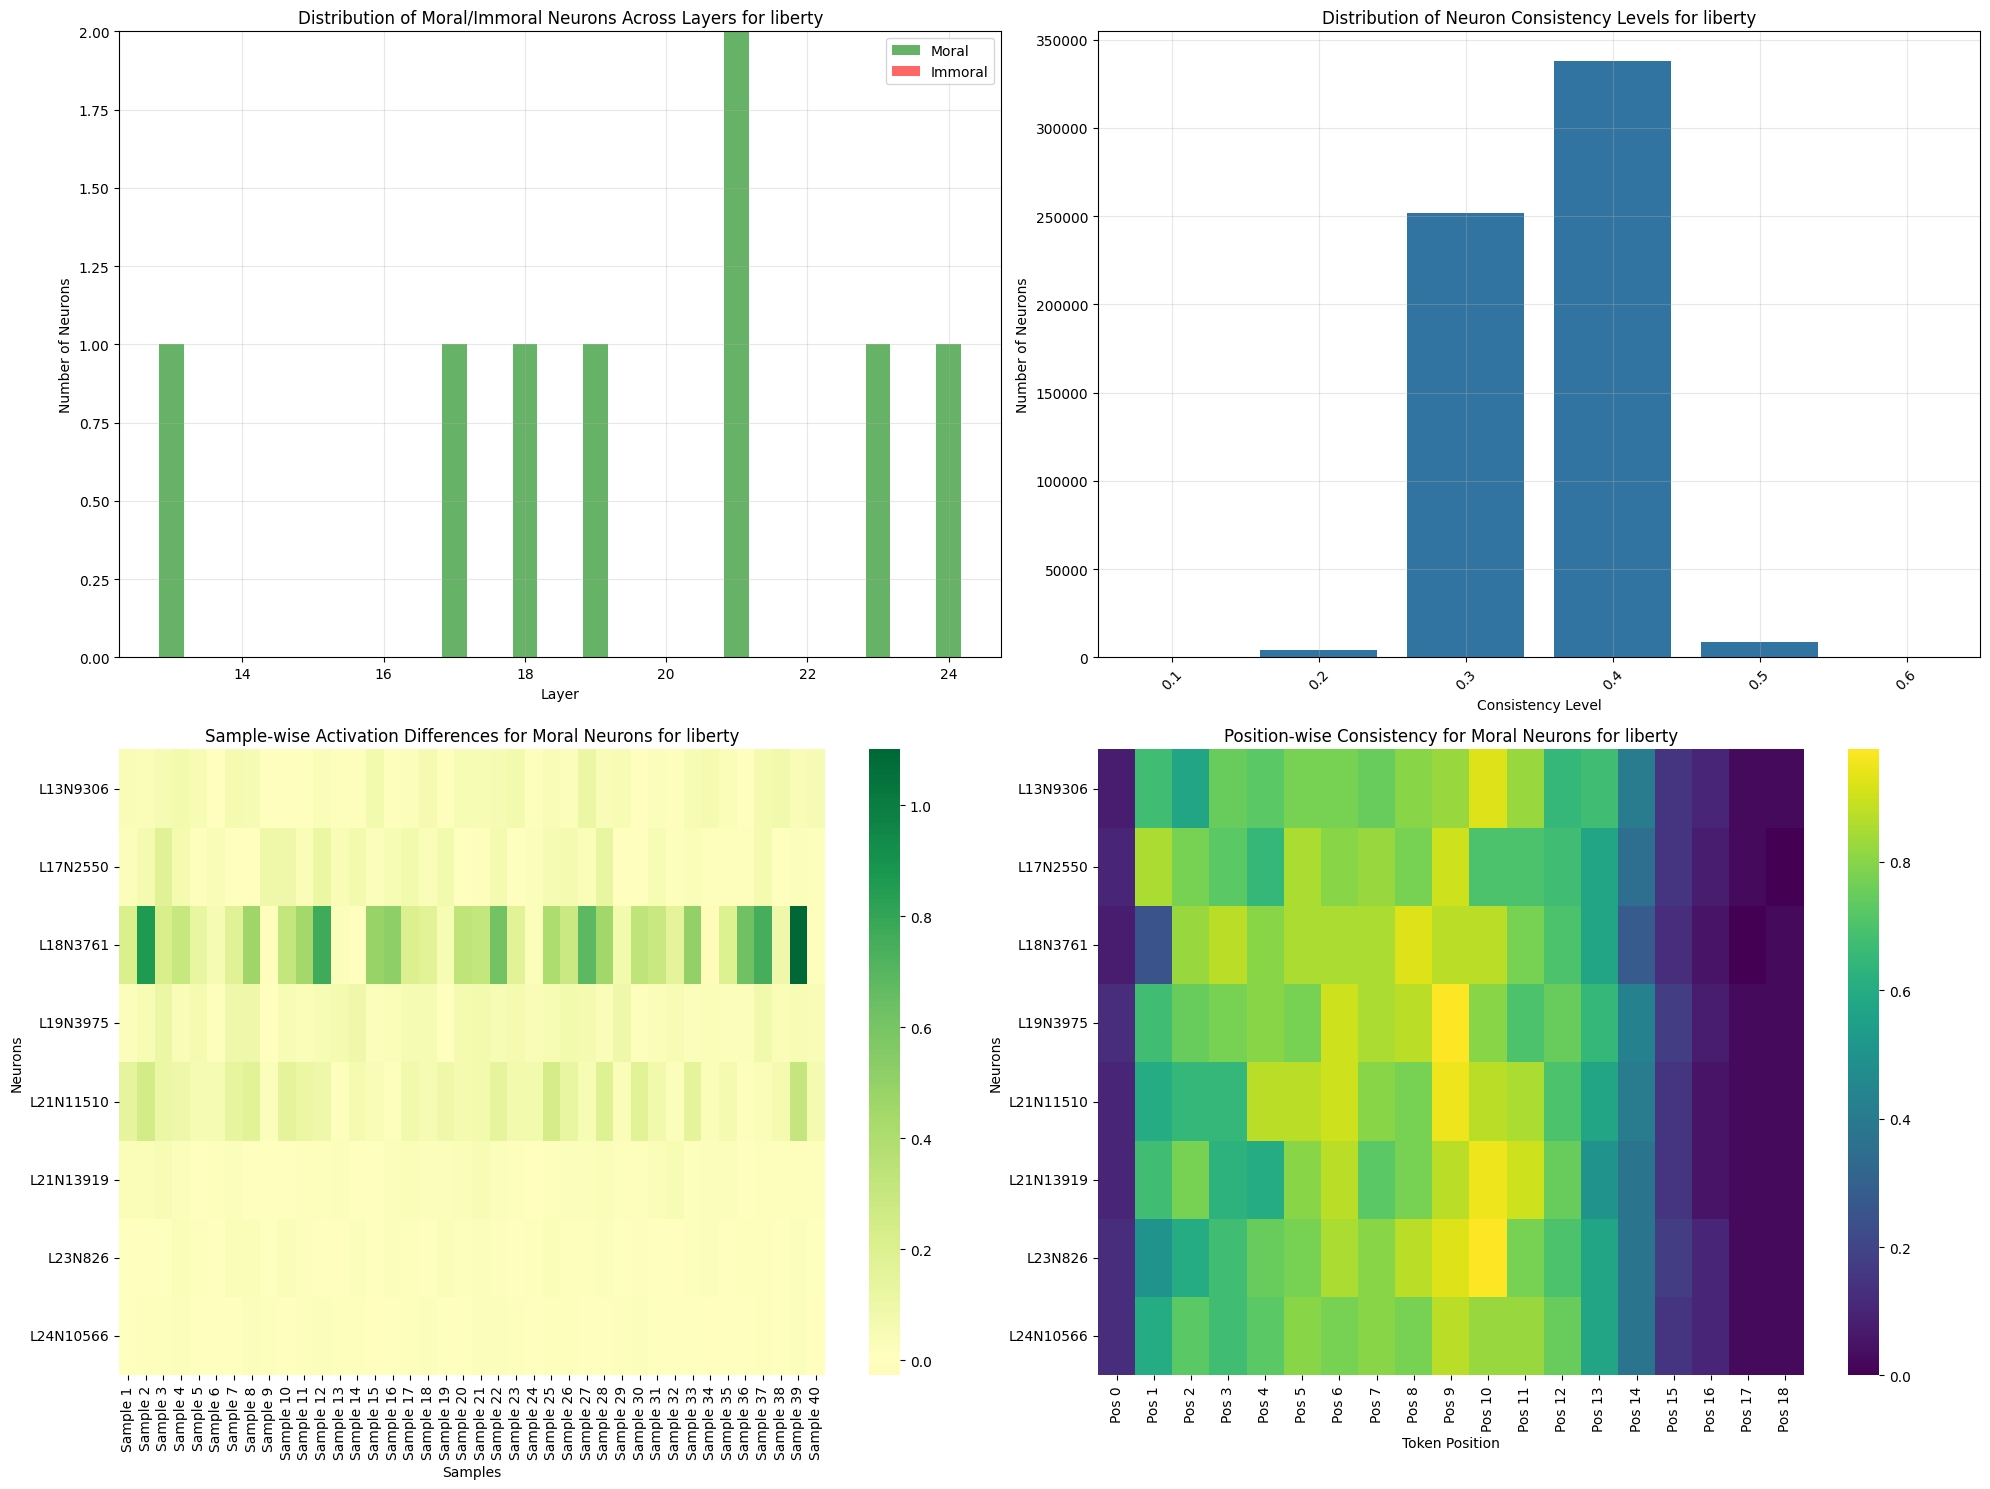

In [17]:
# Visualize the results
from src.visualization.moral_neuron_viz import plot_moral_neuron_analysis
plot_moral_neuron_analysis(results, moral_pairs, save_path="../results/2025-01-17_moral-"+category+"_neuron-analysis.png", dimension=category)


# Neuron Description for a specific neuron

In [ ]:
# Usage
# # Initialize the model
# from transformer_lens import HookedTransformer
# model = HookedTransformer.from_pretrained("gpt2-small")

# # Initialize the evaluator
# evaluator = NeuronEvaluator(model=model)

# # Your input texts to analyze
# texts = [
#     "Example text 1",
#     "Example text 2",
#     # ... more texts ...
# ]

# # Evaluate a specific neuron
# result = evaluator.evaluate_neuron(
#     layer=5,           # layer to analyze
#     neuron_idx=123,    # neuron index to analyze
#     texts=texts        # texts to analyze
# )

# # Print results
# print(f"Neuron Description: {result['description']}")
# print(f"\nTop activating tokens: {result['analysis']['top_tokens']}")
# print(f"Average activation: {result['analysis']['avg_activation']:.3f}")

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from data.mft_dim import moral_foundations, generate_mc_prompts, get_moral_statements, get_moral_keys
from transformer_lens import HookedTransformer
from src.analysis.neuron_describer_v2 import NeuronEvaluator

In [2]:
api_key = ""

In [3]:
import os
os.environ["OPENAI_API_KEY"] = api_key

In [4]:
model = HookedTransformer.from_pretrained("google/gemma-2-9b-it")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/root/miniconda/envs/mech/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Loaded pretrained model google/gemma-2-9b-it into HookedTransformer


In [5]:
evaluator = NeuronEvaluator(model, activation_threshold=0.1, api_key=api_key)  # Lower threshold

In [6]:
moral_statements = get_moral_statements()
# Extract only statements in a list
moral_statements = [statement["statement"] for statement in moral_statements]
moral_statements

['One should always come to the aid of a stranger in distress.',
 'Providing shelter and food to the homeless is our fundamental duty.',
 'We should speak out against bullying to protect vulnerable individuals.',
 'Inflicting physical harm on animals for entertainment is cruel and should be prohibited.',
 'Every child deserves emotional support and reassurance during hard times.',
 'Society should allocate resources to ensure that the sick receive proper medical care.',
 'We have a moral responsibility to report and prevent abuse when we see it.',
 'Comforting someone grieving a loss is a sign of basic human compassion.',
 'Offering support to coworkers under stress fosters a more humane work environment.',
 'Rescuing neglected pets and giving them care demonstrates moral empathy.',
 'Responding kindly when someone makes an honest mistake prevents unnecessary harm.',
 'Seeking help for mental health issues is important; we should encourage one another to do so.',
 'Volunteering at shel

In [9]:
description = []

In [10]:

description.append(evaluator.evaluate_neuron(layer=13, neuron_idx=9306, texts=moral_statements))
description.append(evaluator.evaluate_neuron(layer=17, neuron_idx=2550, texts=moral_statements))


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [1]:

#save descriptipn in a file json file           
import json
with open('description.json', 'w') as f:
    json.dump(description, f)



NameError: name 'description' is not defined